![Colegio Bourbaki](./Images/Bourbaki.png)

## Rudimentos de Machine Learning

### Introducción a Aprendizaje No Supervisado

El aprendizaje no supervisado es una técnica fundamental en el campo de la inteligencia artificial y el aprendizaje automático, donde el objetivo es descubrir patrones ocultos o estructuras intrínsecas en los datos sin necesidad de etiquetas o instrucciones explícitas. A diferencia del aprendizaje supervisado, donde los modelos se entrenan usando datos etiquetados, el aprendizaje no supervisado trabaja con datos que no tienen etiquetas, lo que significa que el sistema intenta aprender la estructura de los datos por sí mismo.

Esta forma de aprendizaje es crucial en situaciones donde recopilar datos etiquetados es demasiado costoso, difícil o impráctico. Permite a los investigadores y a los profesionales hacer frente a una amplia gama de problemas, como la agrupación de clientes con preferencias similares, la detección de anomalías en transacciones financieras o el análisis de grandes volúmenes de datos no estructurados, como textos o imágenes.

Existen varios métodos y algoritmos asociados con el aprendizaje no supervisado, incluyendo el clustering (por ejemplo, K-means, clustering jerárquico), reducción de dimensionalidad (por ejemplo, PCA, t-SNE), y modelos generativos (por ejemplo, autoencoders, GANs). Estos métodos tienen el potencial de revelar insights valiosos y patrones no evidentes a simple vista, impulsando innovaciones y mejorando decisiones en campos como el marketing, la seguridad informática, la genómica, y más allá.

En resumen, el aprendizaje no supervisado representa una herramienta poderosa y versátil en el análisis de datos, ofreciendo la posibilidad de descubrir conocimientos profundos y patrones complejos en grandes conjuntos de datos, todo ello sin la necesidad de intervención o guía humana explícita.


**En esta notebook, nos concentraremos en comparar la clusterización a traves de las técnicas K-Means y DBScan**. También, veremos cómo podemos aprovechar PCA para tales fines.

La actividad principal de las compañías de seguros es permitir a particulares y empresas protegerse contra acontecimientos poco frecuentes pagando una prima pequeña en comparación con los daños eventualmente sufridos.

El Valor de Vida del Cliente (VVC) evalúa el valor del cliente para la Compañía, es decir, es el Valor Actual Neto de los flujos de caja atribuidos a la relación con un cliente. Lo usaremos como etiqueta para mostrar cómo se agrupan bajo la misma al reducir la dimensión. No haremos predicciones de la etiqueta, solo clusterizar los clientes, aunque podría predecirse este target a lo largo del tiempo.

El Aprendizaje No Supervisado describe tareas que implican el uso de un modelo para descubrir una buena representación interna de los datos de entrada útiles para el posterior Aprendizaje Supervisado.

En este trabajo, el Aprendizaje no Supervisado se utiliza para proporcionar una representación de baja dimensión de las entradas y agrupar variables numéricas para proporcionar un mejor análisis de la cartera de clientes. En ambas situaciones, el Aprendizaje no Supervisado puede utilizarse como ingeniería de características.

### Librerías

In [68]:
# Data Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats

# Preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.pca import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Metrics
from sklearn.metrics import silhouette_score

### Funciones de ayuda

In [69]:
def high_correlation_features(dataframe, threshold=0.95):
    """
    Identifies and returns pairs of highly correlated features from the given dataframe.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with pairs of features that have a correlation coefficient above the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Find features with a correlation above the threshold
    # Note: The matrix is symmetric, so we need to filter out one side to avoid duplicates
    high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                       .stack()
                       .reset_index())
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['Correlation']) > threshold, :]

    return high_corr_pairs

In [70]:
def remove_highly_correlated_features(dataframe, threshold=0.95):
    """
    Removes features that are highly correlated with each other above a specified threshold.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with the highly correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    # Drop features 
    reduced_df = dataframe.drop(to_drop, axis=1)
    
    return reduced_df, to_drop

In [71]:
def plot_correlation_matrix(dataframe, plot_graph=True, return_matrix=False):
    """
    Calculates and optionally plots the correlation matrix of a given DataFrame.
    
    Parameters:
    - dataframe: DataFrame from which to calculate the correlation matrix.
    - plot_graph: If True, displays a heatmap of the correlation matrix.
    - return_matrix: If True, returns the correlation matrix.
    
    Returns:
    - If return_matrix is True, returns the correlation matrix of the dataframe.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr('spearman')
    
    # Plot the correlation matrix heatmap if requested
    if plot_graph:
        plt.figure(figsize=(25, 20))
        sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, cmap="hot", annot=True, fmt=".1f", square=True)
        plt.xticks(rotation=45, horizontalalignment='right')
    
    # Return the correlation matrix if requested
    if return_matrix:
        return correlation_matrix

### Carga de datos

In [72]:
data = pd.read_csv("./Data/AutoInsurance.csv")

In [73]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

Como vemos no hay datos nulos, vamos a verificarlo graficamente:

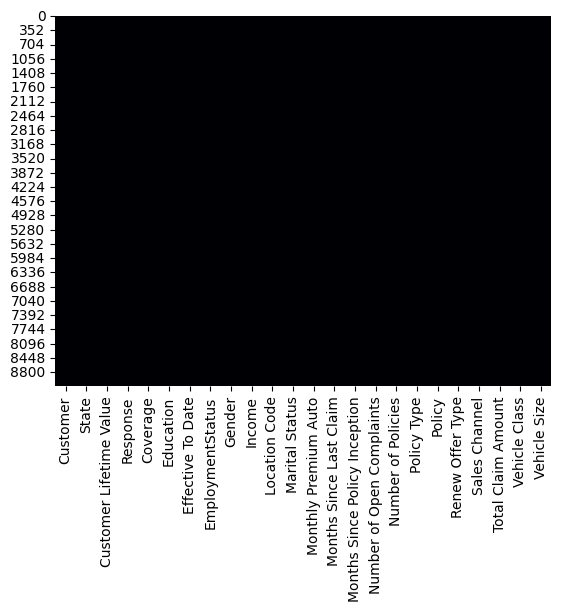

In [75]:
sns.heatmap(data.isnull(), cmap="magma", cbar=False);

Vamos a chequear duplicados:

In [76]:
# check duplicates
data[data.duplicated(['Customer'])]

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size


In [77]:
data.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


### Análisis exploratorio de datos

In [78]:
data['Effective_Date'] = data['Effective To Date'].astype('datetime64[ns]')

In [79]:
# Min Value Effective to Date Policy, Max Value Effective to Date Policy
data['Effective_Date'].min(), data['Effective_Date'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2011-12-02 00:00:00'))

In [80]:
# Detectar características categóricas y numéricas
categorical_features = data.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [81]:
categorical_features

['Customer',
 'State',
 'Response',
 'Coverage',
 'Education',
 'Effective To Date',
 'EmploymentStatus',
 'Gender',
 'Location Code',
 'Marital Status',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

In [82]:
numerical_features

['Customer Lifetime Value',
 'Income',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Total Claim Amount']

In [83]:
# End of Year (eoy) of the current Effective to Date
data['eoy_Effective_Date'] = pd.to_datetime('2011-12-31')

In [84]:
# Days missing to the end of the current year from effective to date
data['eoy_missing_days'] = (data['eoy_Effective_Date'] - data['Effective_Date']).dt.days

In [85]:
data = data.drop(['Customer','Effective To Date','eoy_Effective_Date'], axis=1)

In [86]:
data = data.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

In [87]:
#get categorical features from data
categorical_features = data.select_dtypes(include=["object", "category"]).columns.tolist()

In [88]:
#get numerical features from data
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [89]:
# Mostrar los resultados
print("Características Categóricas:", categorical_features)
print("Características Numéricas:", numerical_features)

Características Categóricas: ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy', 'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size']
Características Numéricas: ['Customer_Lifetime_Value', 'Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days']


In [90]:
print("Número de Características Categóricas:", len(categorical_features))
print("Número de Características Numéricas:", len(numerical_features))

Número de Características Categóricas: 14
Número de Características Numéricas: 9


Veamos la distribución de los datos numéricos:

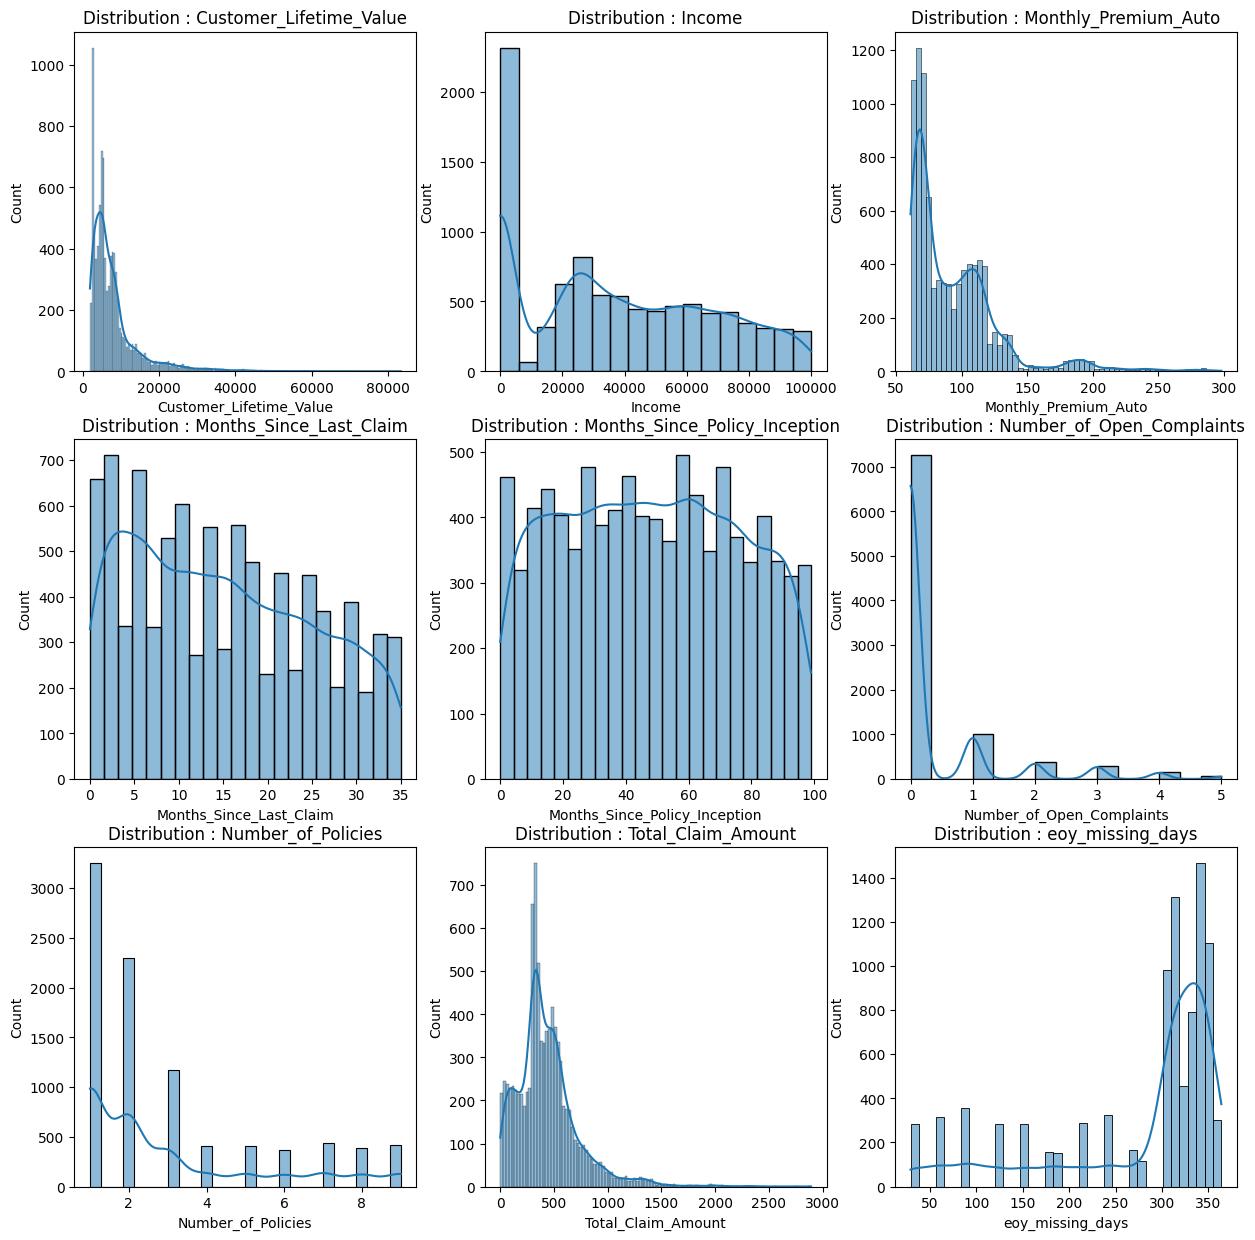

In [91]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i in range(len(numerical_features)):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data[numerical_features[i]], kde=True)
    title = "Distribution : " + numerical_features[i]
    plt.title(title)
plt.show()

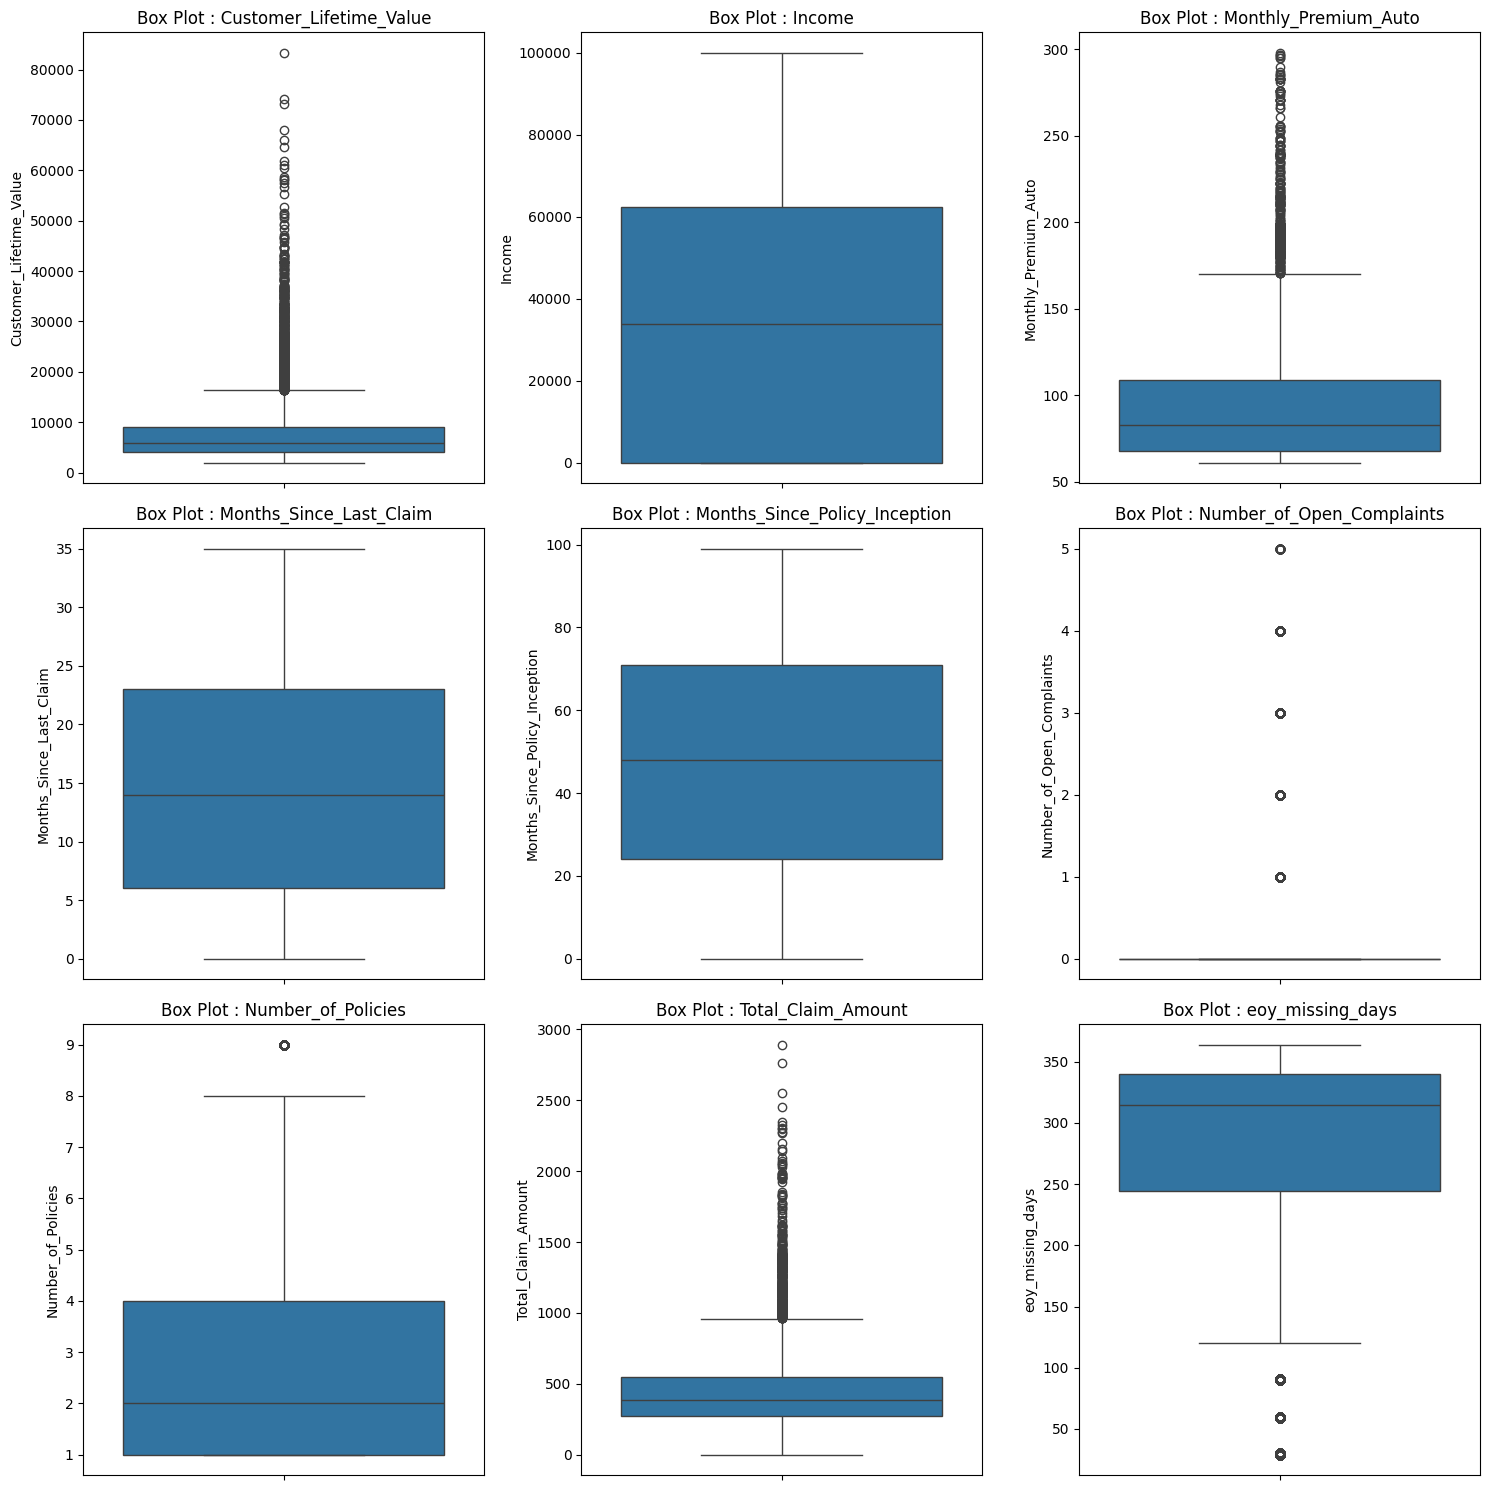

In [92]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i in range(len(numerical_features)):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=data[numerical_features[i]])
    title = "Box Plot : " + numerical_features[i]
    plt.title(title)
plt.tight_layout()
plt.show()

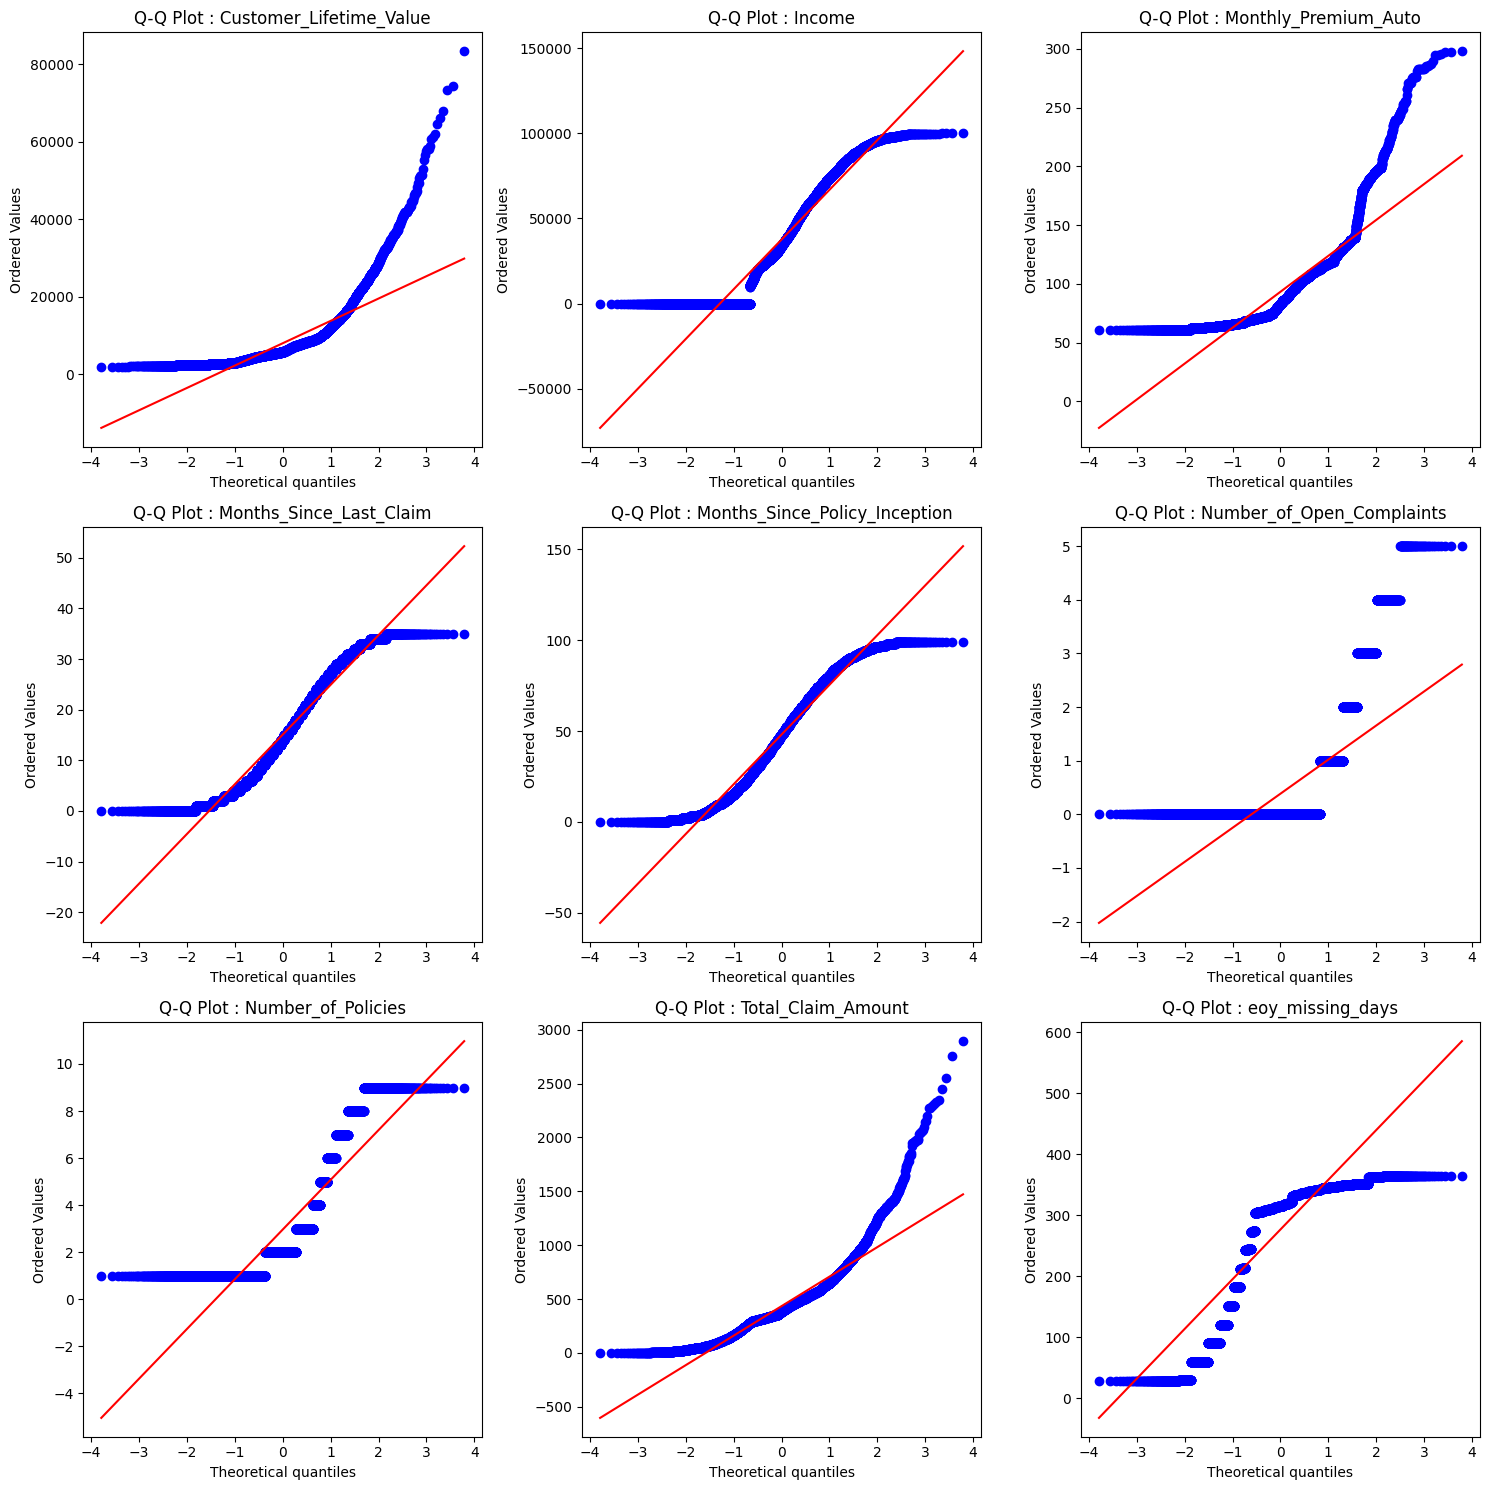

In [93]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i in range(len(numerical_features)):
    plt.subplot(3, 3, i + 1)
    res = stats.probplot(data[numerical_features[i]], plot=plt)
    title = "Q-Q Plot : " + numerical_features[i]
    plt.title(title)
plt.tight_layout()
plt.show()

Veamos el análisis de las componentes categóricas:

In [94]:
# let's have a look at how many labels for categorical features
for col in categorical_features:
    print(col, ': ', len(data[col].unique()), ' labels')

State :  5  labels
Response :  2  labels
Coverage :  3  labels
Education :  5  labels
EmploymentStatus :  5  labels
Gender :  2  labels
Location_Code :  3  labels
Marital_Status :  3  labels
Policy_Type :  3  labels
Policy :  9  labels
Renew_Offer_Type :  4  labels
Sales_Channel :  4  labels
Vehicle_Class :  6  labels
Vehicle_Size :  3  labels


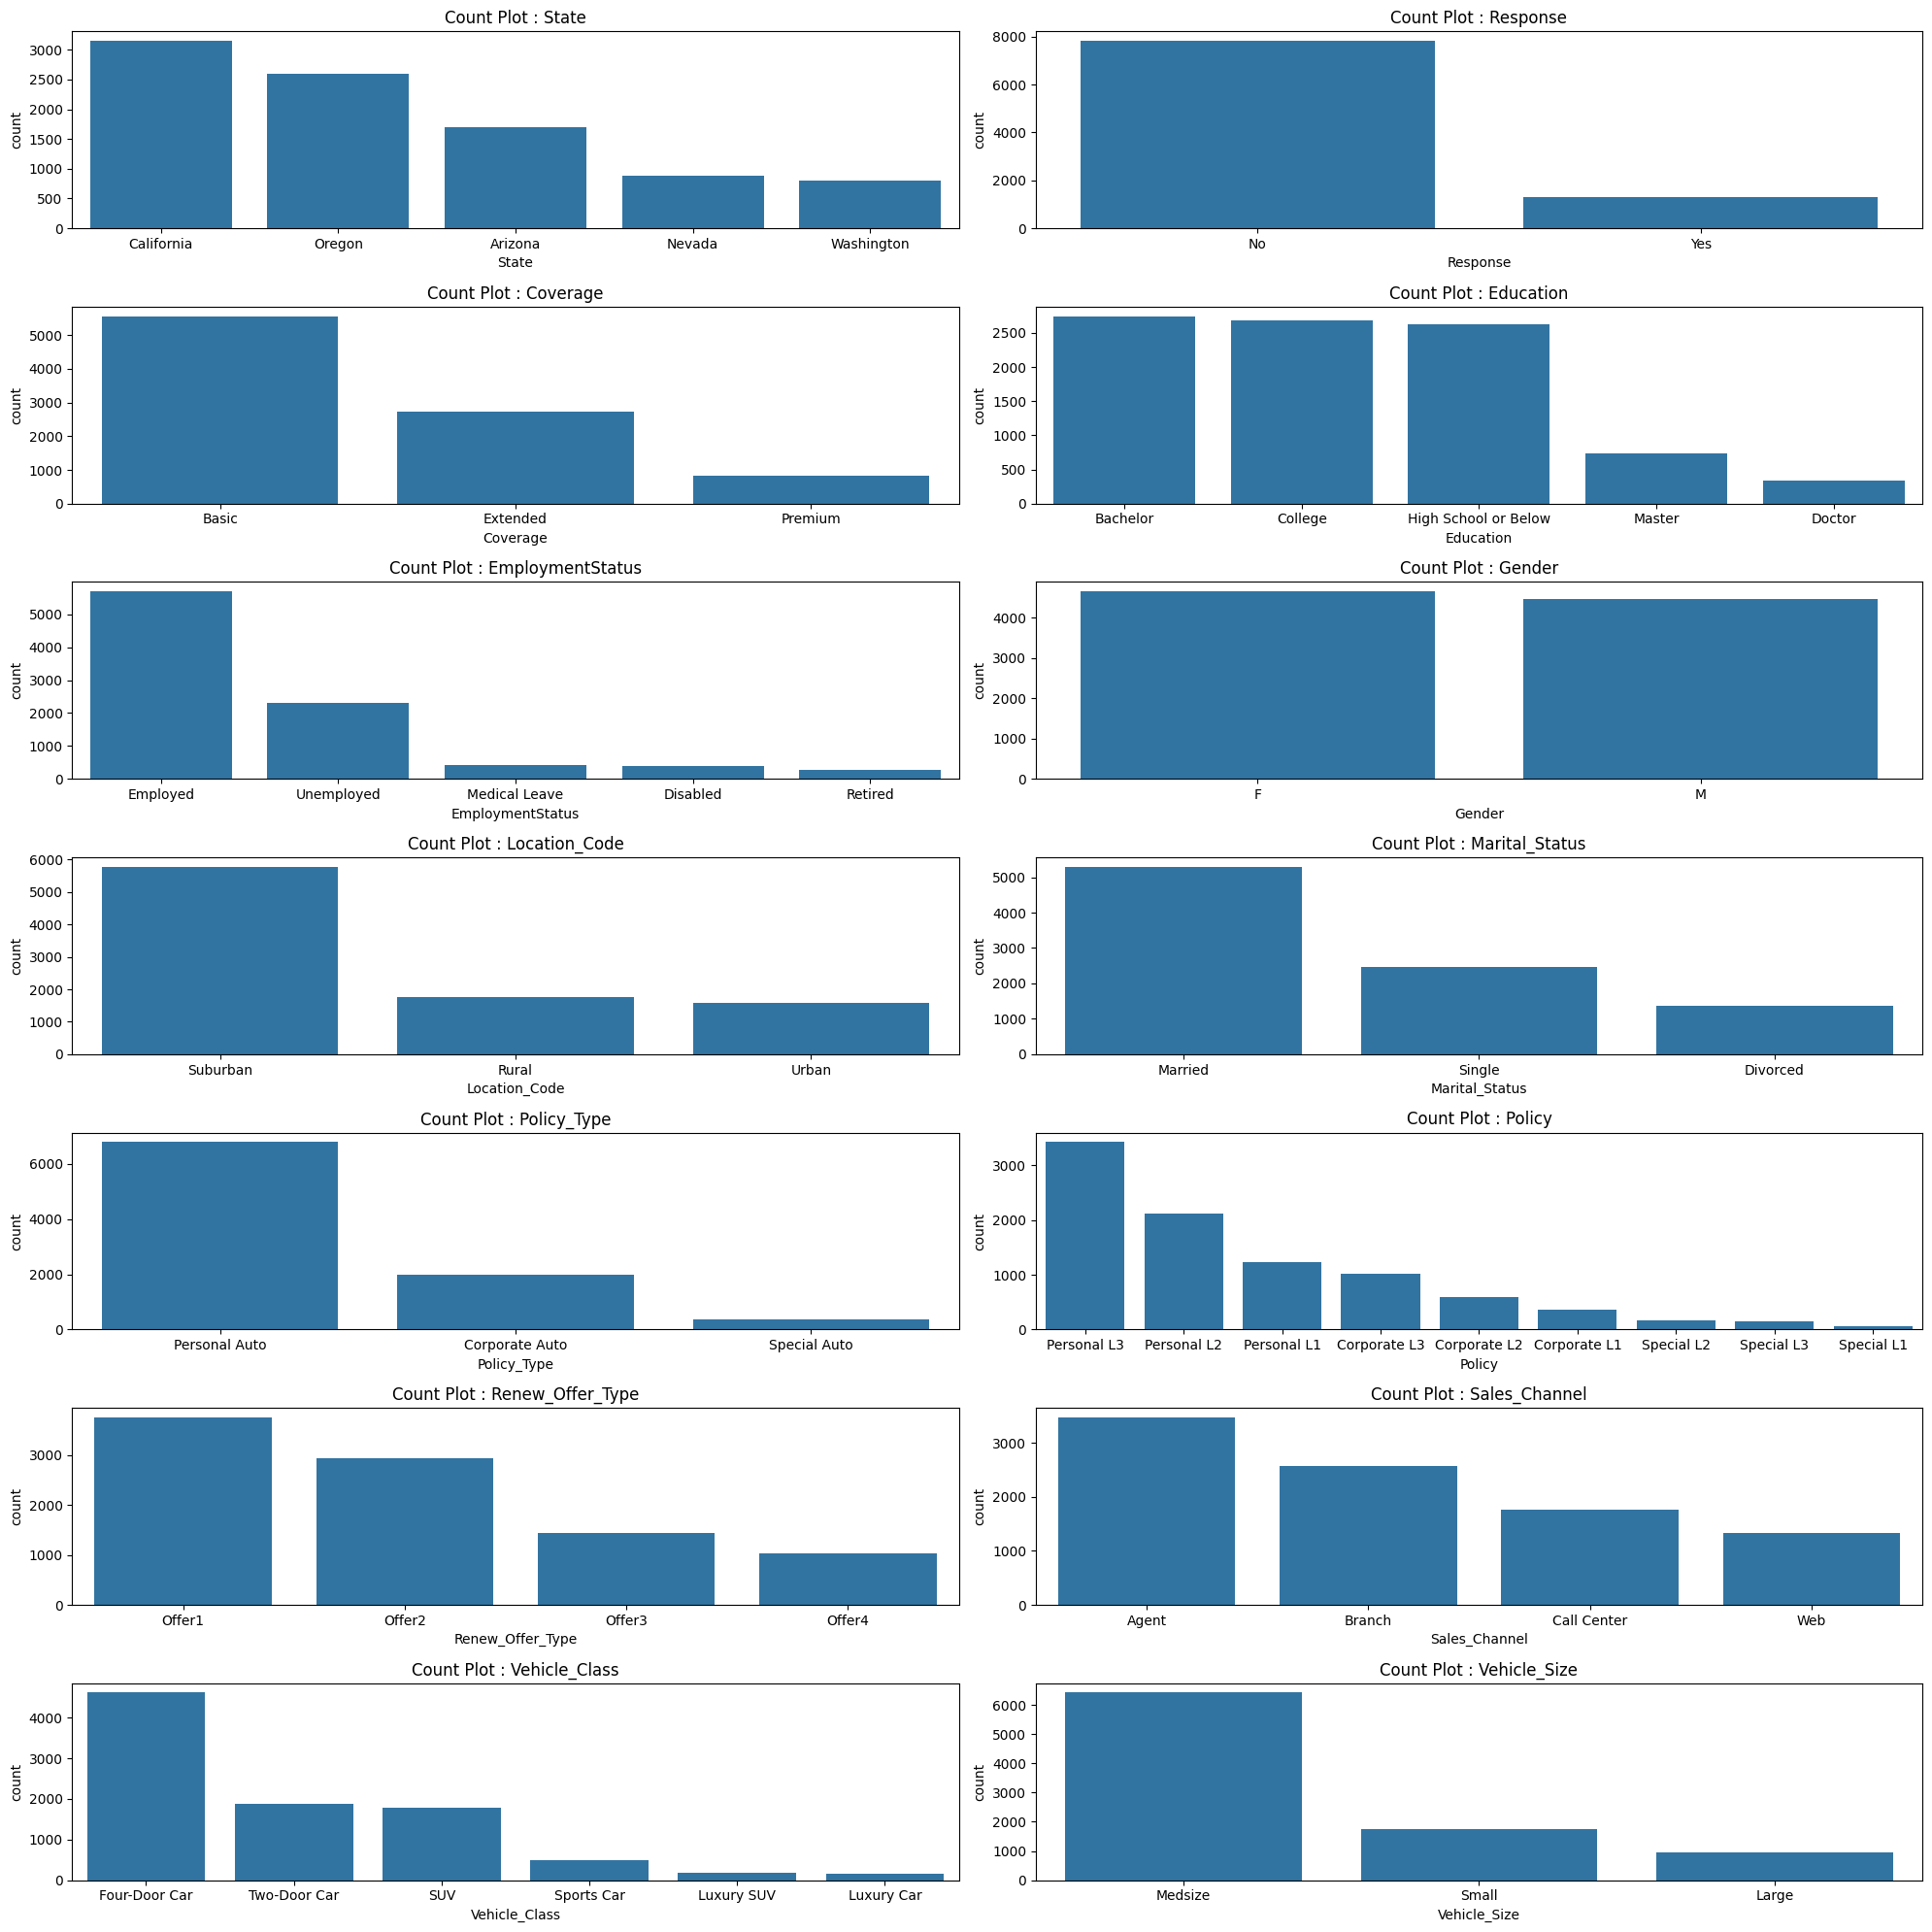

In [95]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20, 20))
for i in range(len(categorical_features)):
    plt.subplot(7, 2, i + 1)
    sns.countplot(x=data[categorical_features[i]], order=data[categorical_features[i]].value_counts().index)
    title = "Count Plot : " + categorical_features[i]
    plt.title(title)
plt.tight_layout()
plt.show()

In [96]:
df = data.copy(deep=True)

In [97]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in data.columns if data[var].dtype=='object']
data[obj_cols].describe().T

,count,unique,top,freq
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location_Code,9134,3,Suburban,5779
Marital_Status,9134,3,Married,5298
Policy_Type,9134,3,Personal Auto,6788
Policy,9134,9,Personal L3,3426


In [98]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in data.columns if data[var].dtype!='object']
data[obj_cols].describe().T

,count,mean,min,25%,50%,75%,max,std
Customer_Lifetime_Value,9134.0,8004.940475,1898.007675,3994.251794,5780.182197,8962.167041,83325.38119,6870.967608
Income,9134.0,37657.380009,0.0,0.0,33889.5,62320.0,99981.0,30379.904734
Monthly_Premium_Auto,9134.0,93.219291,61.0,68.0,83.0,109.0,298.0,34.407967
Months_Since_Last_Claim,9134.0,15.097,0.0,6.0,14.0,23.0,35.0,10.073257
Months_Since_Policy_Inception,9134.0,48.064594,0.0,24.0,48.0,71.0,99.0,27.905991
Number_of_Open_Complaints,9134.0,0.384388,0.0,0.0,0.0,0.0,5.0,0.910384
Number_of_Policies,9134.0,2.96617,1.0,1.0,2.0,4.0,9.0,2.390182
Total_Claim_Amount,9134.0,434.088794,0.099007,272.258244,383.945434,547.514839,2893.239678,290.500092
Effective_Date,9134,2011-03-29 07:59:25.316400384,2011-01-01 00:00:00,2011-01-25 00:00:00,2011-02-19 00:00:00,2011-05-01 00:00:00,2011-12-02 00:00:00,NaN
eoy_missing_days,9134.0,276.667068,29.0,244.0,315.0,340.0,364.0,93.820412


In [99]:
# Split data set in features
X_full = data.copy(deep=True)

### Preprocesamiento

En el dataset tenemos tanto variables categóricas ordinales como nominales:

Variables Ordinales:
* Coverage: Basic, Extended, Premium (si implican un nivel de servicio, pueden ser ordinales)
* Education: High School, Bachelor, Master, Doctorate (podemos suponer un orden natural)
* EmploymentStatus: Unemployed, Employed, Retired (puede ser considerada ordinal si se percibe que el status tiene un orden percibido)
* Renew Offer Type: Offer1, Offer2, Offer3, Offer4 (si están en un secuencia son ordinales)

Variables Nominales:
* State: Names of states (no hay orden inherente)
* Location Code: Code (no hay orden)
* Response: Yes, No (binaria, no hay orden)
* Gender: Male, Female (binaria, no hay orden)
* Policy Type: Corporate Auto, Personal Auto (no hay orden inherente)
* Policy: Corporate L1, Corporate L2, Corporate L3, Personal L1, Personal L2, Personal L3 (no hay orden inherente)
* Sales Channel: Agent, Call Center, Web, Branch (no hay orden inherente)
* Vehicle Class: Two-Door Car, Four-Door Car, SUV (no hay orden inherente)
* Vehicle Size: Small, Medsize, Large (podría considerarse ordenada)
* Marital Status: Single, Married, Divorced (no hay orden)

In [100]:
# Defining the ordinal and nominal categorical variables
ordinal_columns = ['Coverage', 'Education', 'EmploymentStatus', 'Renew_Offer_Type']
nominal_columns = ['State', 'Location_Code', 'Marital_Status', 'Response', 'Gender', 'Policy_Type', 'Policy', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size']

In [101]:
# Define the order for the ordinal columns
ordinal_categories = {
    'Coverage': ['Basic', 'Extended', 'Premium'],
    'Education': ['High School or Below', 'Bachelor', 'Master', 'Doctorate'],
    'EmploymentStatus': ['Unemployed', 'Employed', 'Retired'],
    'Renew_Offer_Type': ['Offer1', 'Offer2', 'Offer3', 'Offer4']
}

In [102]:
#Transform nominal columns
data = pd.get_dummies(data, columns=nominal_columns)

In [103]:
# Transforming ordinal columns
for column, categories in ordinal_categories.items():
    data[column] = data[column].astype(pd.CategoricalDtype(categories=categories, ordered=True)).cat.codes

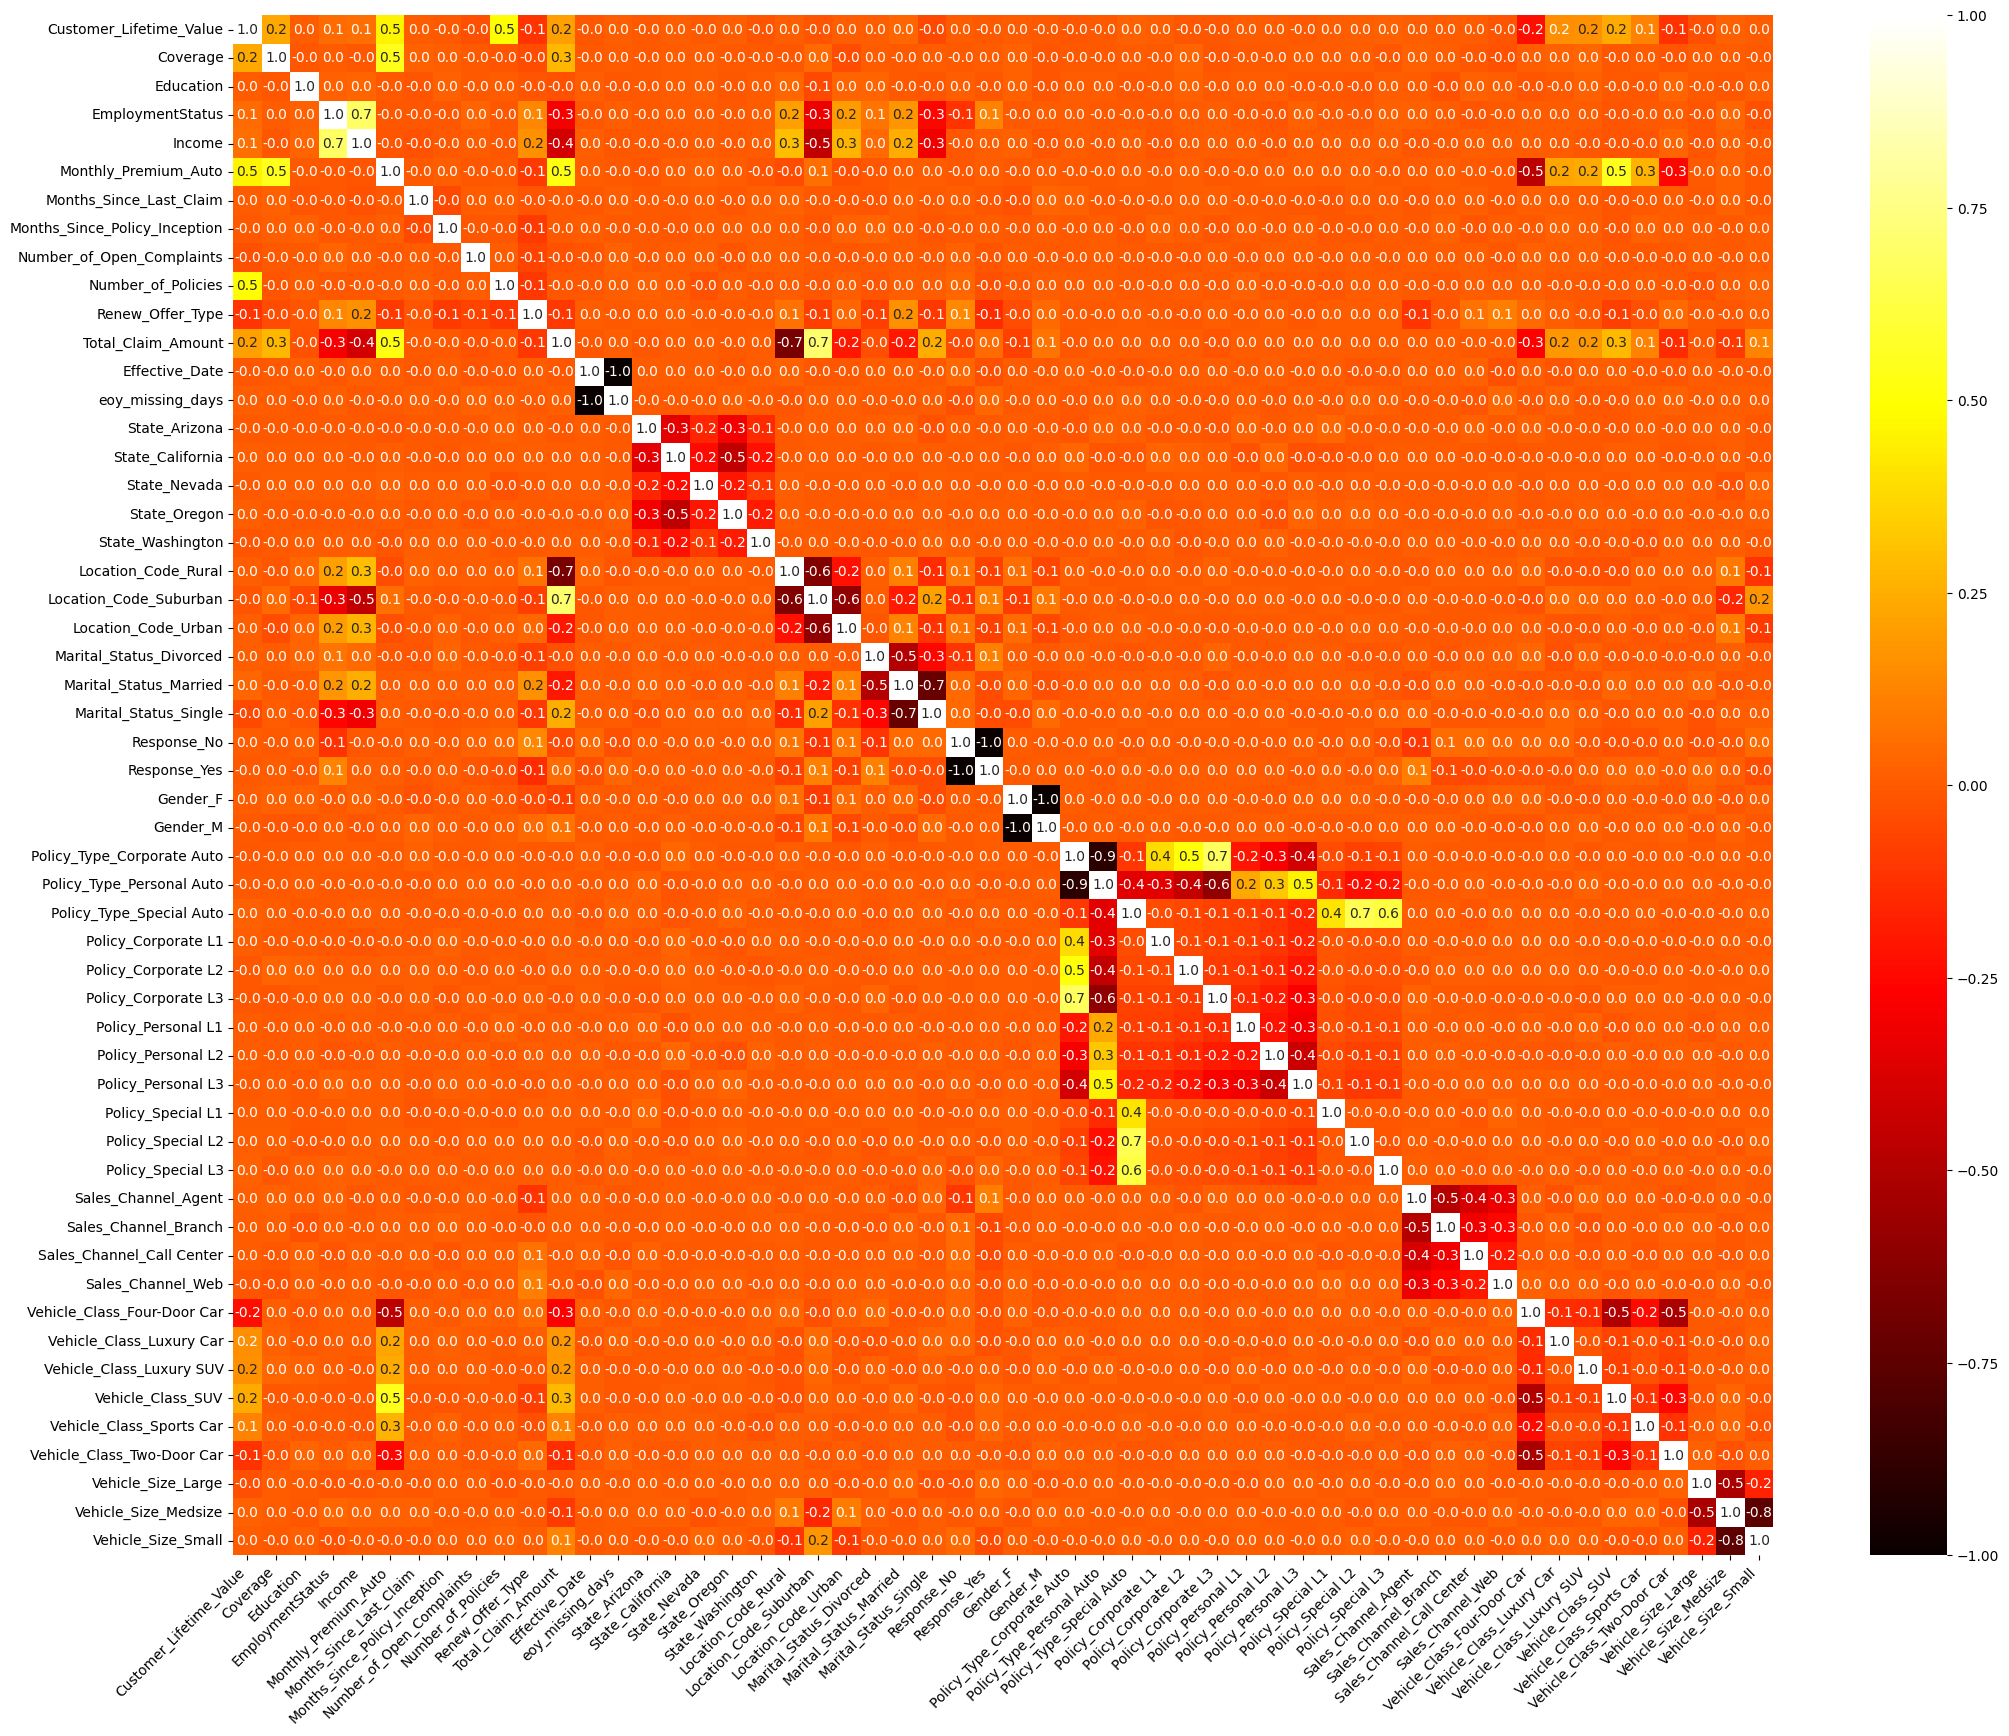

In [104]:
plot_correlation_matrix(data, plot_graph=True, return_matrix=False)

In [105]:
high_correlation_features(data, threshold=0.95)

,Feature 1,Feature 2,Correlation
570,Effective_Date,eoy_missing_days,-1.0
1025,Response_No,Response_Yes,-1.0
1080,Gender_F,Gender_M,-1.0


In [106]:
data.drop('Effective_Date', axis=1, inplace=True)

### Reducción de la dimensionalidad

In [107]:
data.shape

(9134, 53)

In [108]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

In [109]:
pca_2Dmodel = PCA(data, ncomp=2, standardize=True, normalize=True)

In [110]:
pca_2Dmodel.factors

,comp_0,comp_1
0,-0.005363,0.018562
1,0.012531,-0.006484
2,0.003224,-0.006623
3,0.007533,0.018663
4,-0.008653,-0.005496
...,...,...
9129,-0.012185,-0.005566
9130,0.001060,0.020032
9131,0.010959,0.018772
9132,0.003710,-0.005377


In [111]:
data['Customer_Lifetime_Value'].describe()

count     9134.000000
mean      8004.940475
std       6870.967608
min       1898.007675
25%       3994.251794
50%       5780.182197
75%       8962.167041
max      83325.381190
Name: Customer_Lifetime_Value, dtype: float64

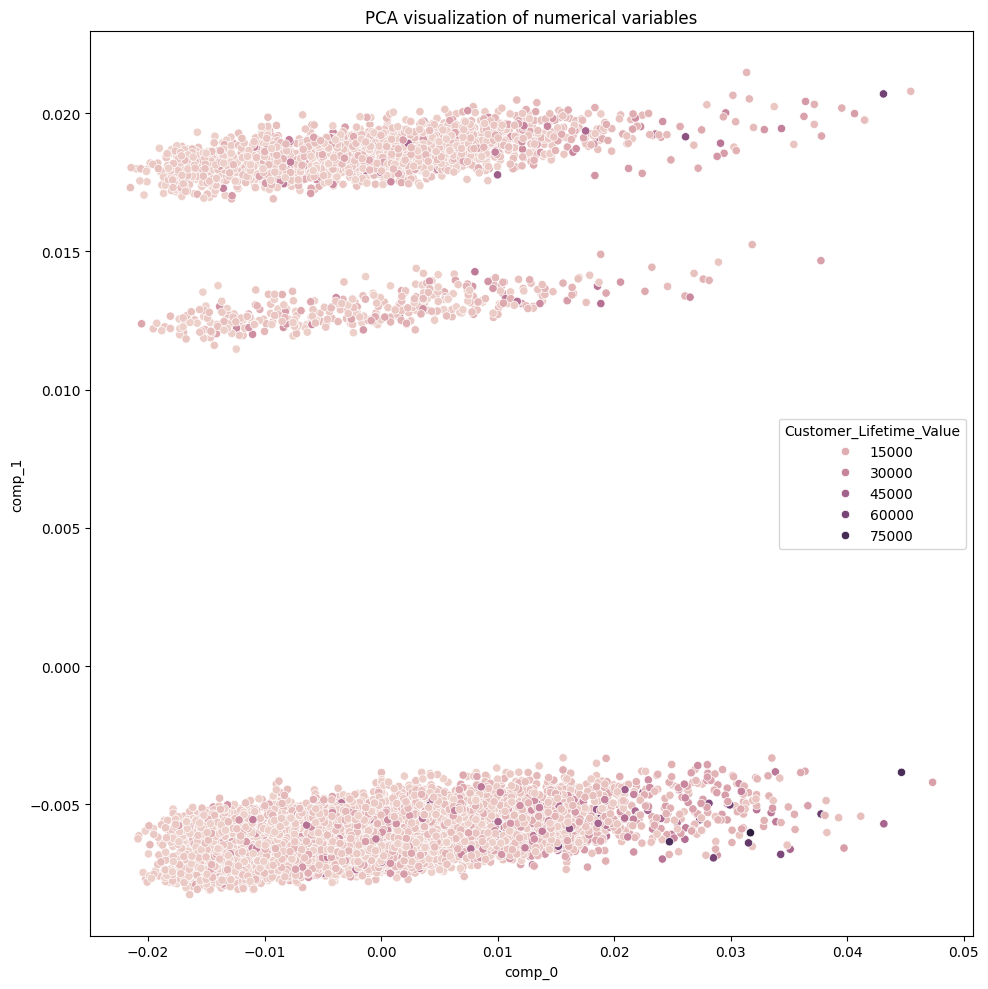

In [112]:
dff = pd.concat([data['Customer_Lifetime_Value'], pca_2Dmodel.factors], axis=1)
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=dff, x='comp_0',y='comp_1',hue='Customer_Lifetime_Value')
plt.title('PCA visualization of numerical variables')
plt.tight_layout()
plt.show()

Veamos con 3 componentes:

In [113]:
pca_3Dmodel = PCA(data, ncomp=3, standardize=True, normalize=True)

In [114]:
pca_3Dmodel.factors

,comp_0,comp_1,comp_2
0,-0.005363,0.018562,0.001732
1,0.012531,-0.006484,0.008392
2,0.003224,-0.006623,-0.009335
3,0.007533,0.018663,-0.002216
4,-0.008653,-0.005496,0.007733
...,...,...,...
9129,-0.012185,-0.005566,-0.008029
9130,0.001060,0.020032,0.008126
9131,0.010959,0.018772,0.011704
9132,0.003710,-0.005377,0.004205


In [115]:
dff = pd.concat([data['Customer_Lifetime_Value'], pca_3Dmodel.factors], axis=1)

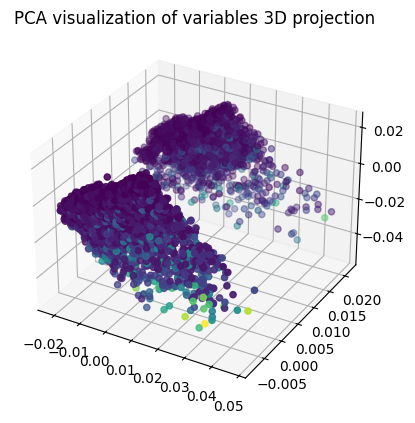

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dff['comp_0']
y = dff['comp_1']
z = dff['comp_2']
d= dff['Customer_Lifetime_Value']
ax.scatter(x,y,z,c=d)
plt.title('PCA visualization of variables 3D projection')
plt.show()

### Clustering con K-Means

**K-Means Clustering** es un algoritmo basado en la distancia que se utiliza para el aprendizaje no supervisado que **no admite características categóricas**.

* Es un algoritmo muy utilizado para tratar con **Aprendizaje no supervisado** que hace el trabajo de encontrar clusters en los datos pero con un enfoque matemático:
    - Selecciona 2 (supongamos k = 2) centroides al azar.
    - Se calcula la distancia entre los centroides y todos los puntos de datos.
    - Si el punto de datos está más cerca de uno de los centroides, entonces se etiqueta como ese centroide y viceversa.
    - Para los 2 conglomerados formados, se calcula el valor medio de los puntos de datos agrupados con cualquiera de los centroides y estos valores medios se definen como los nuevos conglomerados.
    - Este proceso se repite hasta que ambos centroides convergen en puntos fijos.

* hiperparámetro **k** : Define el número de conglomerados o grupos en que se dividirán los datos. Para la selección de los valores de **k**, utilizamos 2 pruebas estadísticas :
    - **Método del arco** : Es un método que representa gráficamente la suma del error cuadrático para un intervalo de valores de **k**. Si este gráfico se parece a un brazo, entonces **k** es el valor que se parece a un **codo** es seleccionado. A partir de este valor de **codo**, la suma de valores al cuadrado (inercia) empieza a disminuir de forma lineal y, por tanto, se considera un valor óptimo.
    - **Método de la puntuación de la silueta** : Se trata de un método que evalúa la calidad de los conglomerados en función del grado de agrupación de los puntos de datos con otros puntos de datos similares.

In [117]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

In [118]:
sse = {}
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', algorithm='lloyd').fit(data_std)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    labels = kmeans.labels_
    sil.append(silhouette_score(data_std, labels, metric = 'euclidean'))

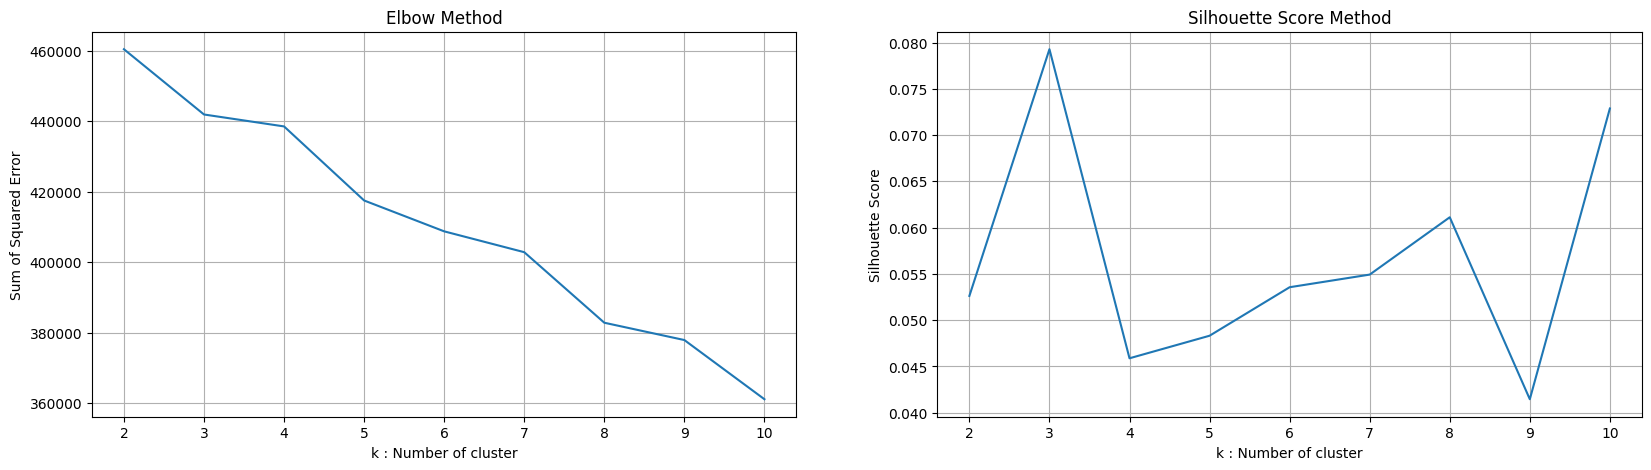

In [119]:
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method : Sum of Squared Error
plt.subplot(1,2,1)
sns.lineplot(x = list(sse.keys()), y = list(sse.values()))
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid(True)

# Silhouette Score Method
plt.subplot(1,2,2)
sns.lineplot(x = range(2,kmax + 1), y = sil)
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [120]:
kmeans = KMeans(n_clusters=5, init='k-means++',n_init='auto', algorithm='lloyd').fit(data_std)
labels = kmeans.predict(data_std)

In [121]:
cluster_num = data.copy()
cluster_num['kmeans_cluster'] = labels
cluster_num['kmeans_cluster'].value_counts()

kmeans_cluster
2    3846
4    1755
0    1688
3    1486
1     359
Name: count, dtype: int64

In [122]:
#print the silhouette score
print(f"Para K-Means: {silhouette_score(data_std, labels, metric = 'euclidean')}")

Para K-Means: 0.06032671177187903


Veamos que pasa en 2 dimensiones:

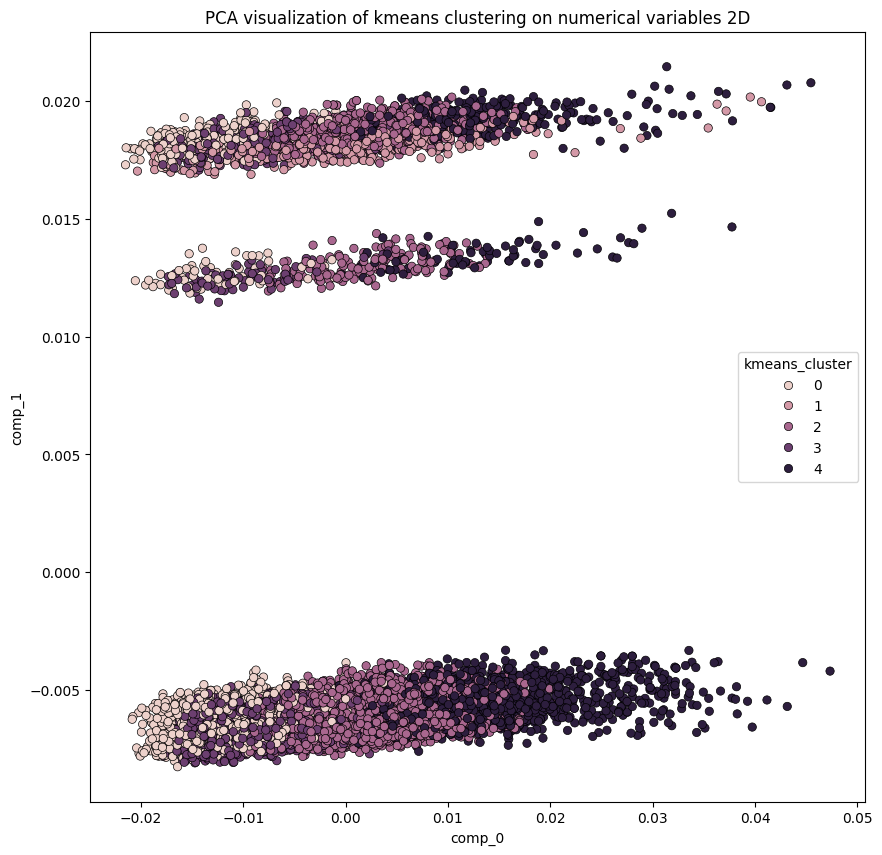

In [123]:
dff_km = pd.concat([cluster_num['kmeans_cluster'], pca_2Dmodel.factors], axis=1)
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='comp_0',y='comp_1',hue='kmeans_cluster',data=dff_km,edgecolor="black")
plt.title('PCA visualization of kmeans clustering on numerical variables 2D')
plt.show()

Veamos que pasa en 3 dimensiones:

In [124]:
dff_km = pd.concat([cluster_num['kmeans_cluster'], pca_3Dmodel.factors], axis=1)

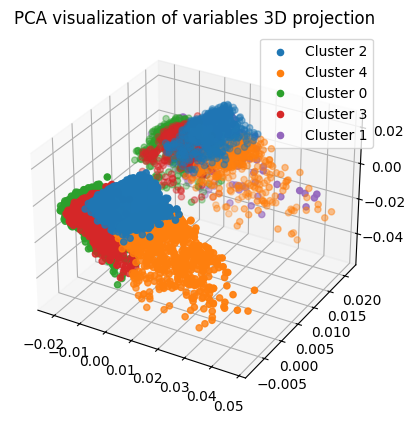

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dff_km['comp_0']
y = dff_km['comp_1']
z = dff_km['comp_2']
d = dff_km['kmeans_cluster']

# Get unique cluster labels
clusters = d.unique()

# Plot each cluster separately to create a legend
for cluster in clusters:
    ax.scatter(x[d == cluster], y[d == cluster], z[d == cluster], label=f'Cluster {cluster}')

# Create a legend
legend = ax.legend(loc='upper right')

plt.title('PCA visualization of variables 3D projection')
plt.show()

### DBSCAN: Density Based Spatial Clustering of Application with Noise Clustering

**DBSCAN Clustering** es un algoritmo de clustering basado en la densidad que se utiliza para problemas de aprendizaje no supervisado.
- En un intento de eliminar los problemas de **K-Means Clustering** con datos anidados y datos de alta dimensión, **DBSCAN Clustering** ¡los elimina! Tiene 3 términos y 2 hiperparámetros importantes:
    - Términos :
        - **Punto central** : Es el punto central que tiene **minPts** número de puntos de datos presentes en su área y los puntos bajo su área pueden extender el cluster.
        - **Punto no central** : Es el punto central que no tiene **minPts** número de puntos de datos presentes en su área y no puede extender el cluster.
        - **Outliers / Ruido** : Son los puntos de datos que no forman parte de ningún cluster.
    - Hiperparámetros :
        - **minPts** : Es el número mínimo de puntos de datos que deben estar presentes en el área de un punto para ser considerado como un punto central.
        - **Épsilon** : Es el radio del área de un punto central.
- **DBSCAN Clustering** crea los clusters de la siguiente manera :        
    - Seleccionar un punto al azar y considerarlo como punto central a partir de los datos. 
    - Compruebe los otros puntos de datos que se presentan en el área de este punto central con el valor **Epsilon** como su radio.
    - Si esta área tiene **minPts** número de puntos de datos en ella, entonces el punto central se considera como un **punto central**.
    - Los puntos de datos de esta zona se consideran **puntos centrales** que se amplían con las mismas reglas creando un conglomerado. 
    - Si alguno de los puntos no cumple las reglas, se considera un **punto no central** que sigue formando parte del conglomerado, pero no puede ampliarlo más.
    - Cuando todos los **puntos centrales** terminan de englobar a los demás puntos de datos, se incluyen los **puntos no centrales** y se completa el cluster.
    - El siguiente cluster comienza a formarse siguiendo las mismas reglas. Algunos de los puntos no forman parte de ninguno de los clusters, estos puntos se conocen como **outliers / ruido**.
- Como se habrá dado cuenta, los hiperparámetros desempeñan un papel crucial en este proceso. Por lo tanto, tienen ciertas reglas para asignarles valores :
    - **minPts** : Si D representa el número de dimensiones / características de un conjunto de datos, entonces **minPts** >= D + 1. Normalmente, **minPts** >= 2 * D se selecciona para conjuntos de datos más pequeños o ruidosos. 
    - **Épsilon** : Su valor suele decidirse utilizando el gráfico de distancia **k** que se determina a partir del modelo **KNN**. Se selecciona el valor en el que el gráfico cambia bruscamente.

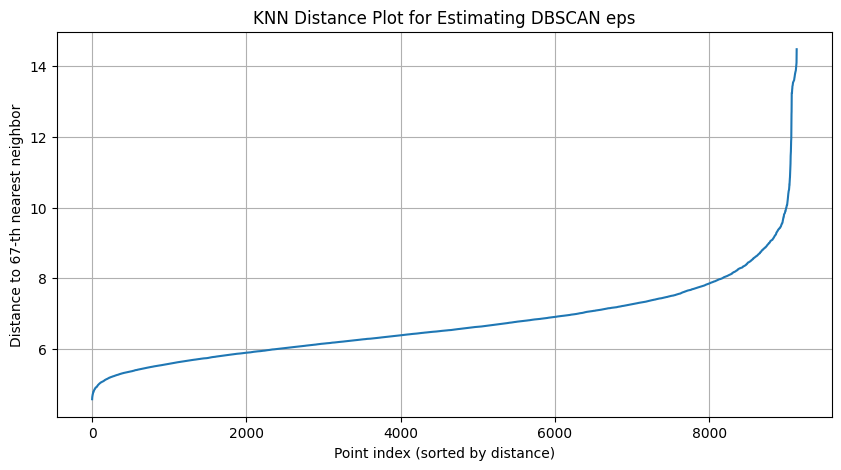

In [126]:
# Using NearestNeighbors to find the distance to the k-th nearest neighbor
k = 67 # As suggested for min_samples in DBSCAN
nn = NearestNeighbors(n_neighbors=k)
nn.fit(data_std)
distances, indices = nn.kneighbors(data_std)

# Sorting the distances
sorted_distances = np.sort(distances[:, k-1], axis=0)

# Plotting the KNN distance plot
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.grid(True)
plt.title('KNN Distance Plot for Estimating DBSCAN eps')
plt.xlabel('Point index (sorted by distance)')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.show()

In [127]:
db = DBSCAN(min_samples=67, eps=8.5).fit(data_std)
labels = db.labels_

In [128]:
#print the silhouette score
print(f"Para DBSCAN: {silhouette_score(data_std, labels, metric = 'euclidean')}")

Para DBSCAN: 0.25979258873725347


In [129]:
# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

Number of Clusters :  3
Number of Outliers :  111


In [130]:
cluster_num = data.copy()
cluster_num['dbscan_cluster'] = labels
cluster_num['dbscan_cluster'].value_counts()

dbscan_cluster
 0    8724
 1     157
 2     142
-1     111
Name: count, dtype: int64

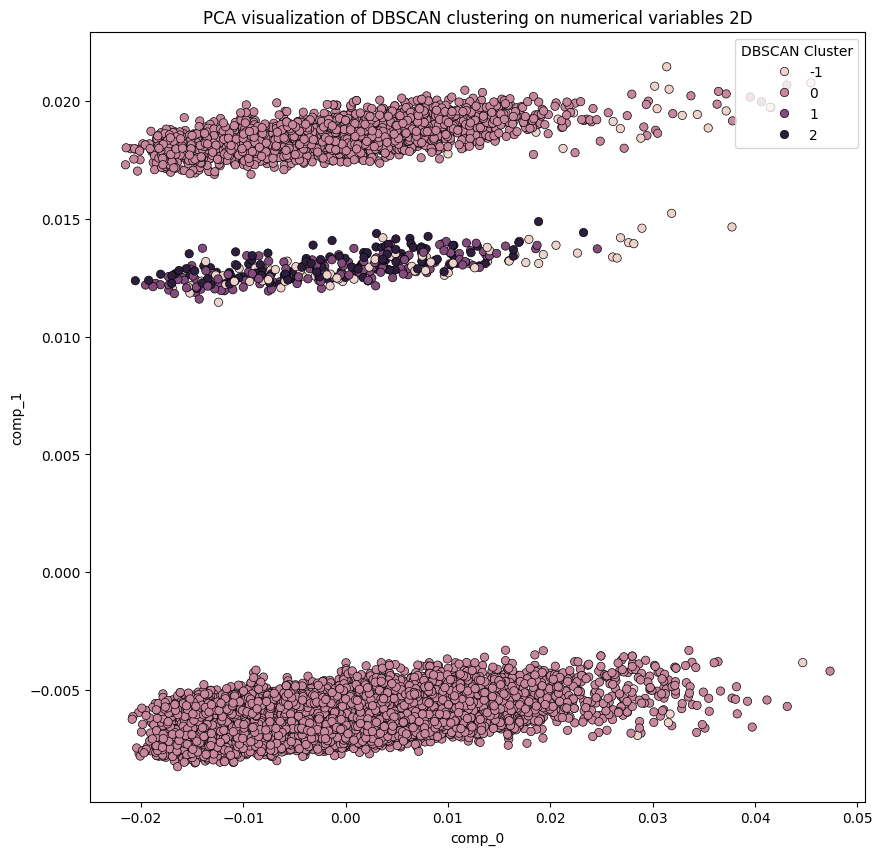

In [131]:
dff_db = pd.concat([cluster_num['dbscan_cluster'], pca_2Dmodel.factors], axis=1)

plt.figure(figsize=(10, 10))
sns.scatterplot(x='comp_0', y='comp_1', hue='dbscan_cluster', data=dff_db, edgecolor="black")

# Add legend
plt.legend(title='DBSCAN Cluster', loc='upper right')

plt.title('PCA visualization of DBSCAN clustering on numerical variables 2D')
plt.show()

In [132]:
dff_db = pd.concat([cluster_num['dbscan_cluster'], pca_3Dmodel.factors], axis=1)

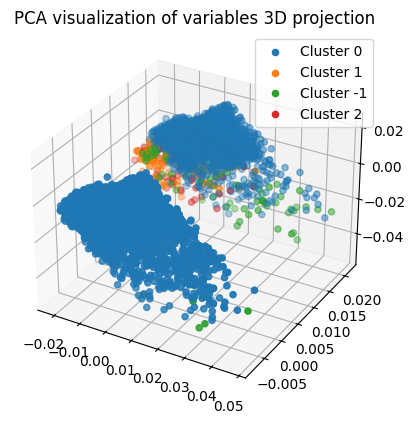

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dff_db['comp_0']
y = dff_db['comp_1']
z = dff_db['comp_2']
d = dff_db['dbscan_cluster']

# Get unique cluster labels
clusters = d.unique()

# Plot each cluster separately to create a legend
for cluster in clusters:
    ax.scatter(x[d == cluster], y[d == cluster], z[d == cluster], label=f'Cluster {cluster}')

# Create a legend
legend = ax.legend(loc='upper right')

plt.title('PCA visualization of variables 3D projection')
plt.show()

K-Means y DBSCAN son algoritmos de clustering con enfoques diferentes y, por lo tanto, tienen fortalezas y debilidades distintas en diferentes situaciones.

Aquí hay algunas razones por las cuales K-Means podría ser mejor que DBSCAN en ciertos casos:

* Forma de los Clústeres: K-Means tiende a producir clústeres de forma convexa debido a su enfoque de minimización de la suma de cuadrados de las distancias al cuadrado. Si los clústeres en tus datos tienen formas bien definidas y son aproximadamente esféricos, K-Means podría funcionar mejor.

* Tamaño Uniforme de los Clústeres: K-Means intenta dividir el conjunto de datos en un número predeterminado de clústeres de aproximadamente igual tamaño. Si tus datos tienen clústeres de tamaño similar y deseas una partición clara del espacio de características en un número específico de clústeres, K-Means podría ser más adecuado.

* Eficiencia Computacional: K-Means es computacionalmente más eficiente que DBSCAN, especialmente en conjuntos de datos grandes. DBSCAN puede volverse computacionalmente costoso en conjuntos de datos de alta dimensionalidad debido a la necesidad de calcular la distancia entre cada par de puntos.

* Fácil Implementación y Interpretación: K-Means es más simple de entender e implementar en comparación con DBSCAN. Tiene menos hiperparámetros para ajustar y es más fácil de interpretar los resultados.

Sin embargo, DBSCAN puede ser más apropiado en ciertos escenarios:

* Clústeres de Densidad Variable: DBSCAN puede identificar clústeres de cualquier forma y tamaño y es robusto ante la presencia de ruido y clústeres de densidad variable.

* Clústeres de Forma Arbitraria: Si los clústeres en tus datos tienen formas no convexas o están muy juntos, DBSCAN puede ser más efectivo que K-Means.

* Identificación de Ruido: DBSCAN tiene la capacidad de identificar puntos atípicos o ruido en tus datos como puntos que no pertenecen a ningún clúster.

En resumen, la elección entre K-Means y DBSCAN depende de la naturaleza de tus datos, la forma y densidad de los clústeres que estás tratando de identificar, así como de tus objetivos específicos de clustering. Es importante probar ambos algoritmos y evaluar su rendimiento en función de métricas relevantes y la interpretación de los resultados en el contexto de tu problema específico.

### Ejercicio

* **Graficar los centroides de KMeans y DBScan.** Chequear la documentación para ver cómo extraerlos
* Calcular la varianza explicada para 2 y 3 dimensiones
* DBSCAN: tratar de mejorar el agrupamiento realizado
* Realizar la reducción de la dimensión con el método t-SNE y observar qué sucede. Se procede de manera similar a PCA.

### Preguntas

**KMeans:**

* ¿Cuál es el objetivo principal de KMeans en el clustering?
* Describe brevemente cómo funciona el algoritmo KMeans.
* ¿Qué son los centroides en el contexto de KMeans y cómo se utilizan para definir clústeres?
* ¿Cómo se inicializan los centroides en KMeans y cómo puede afectar esto la solución final?
* ¿Cómo se determina el número óptimo de clústeres en KMeans y qué métodos pueden utilizarse para esta determinación?

**DBSCAN:**

* ¿Cuál es el concepto principal detrás de DBSCAN en comparación con otros algoritmos de clustering?
* Describe el concepto de "puntos núcleo" (core points) en DBSCAN y cómo se utilizan para identificar clústeres.
* ¿Qué son los "puntos frontera" (border points) y los "puntos ruido" (noise points) en DBSCAN?
* ¿Cómo se ajustan los parámetros epsilon (ε) y minPoints en DBSCAN y qué efecto tienen en la agrupación de datos?
* ¿Qué tipo de estructuras de datos o conjuntos de datos son más adecuados para DBSCAN y por qué?

**Preguntas comparativas:**

* ¿Cuáles son las principales diferencias entre DBSCAN y KMeans en términos de enfoque de clustering y suposiciones subyacentes?
* ¿En qué situaciones podrías preferir usar DBSCAN sobre KMeans y viceversa? Proporciona ejemplos concretos.
* ¿Cómo afectan las formas y densidades de los clústeres en tus datos a la elección entre DBSCAN y KMeans?
* ¿Qué métricas o métodos podrías utilizar para evaluar la calidad de los clústeres generados por DBSCAN y KMeans?
* ¿Cuáles son algunas de las ventajas y desventajas de cada algoritmo en términos de escalabilidad, interpretación y robustez frente a datos ruidosos?

### Adapatado de:

* Unsupervised Learning applied to the Customer Lifetime Value (CLV): https://github.com/claudio1975/Customer_Lifetime_Value/

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)